In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!pip install matplotlib==3.2.2
! pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [24]:
def preprocess_fn(data):
  image = data['image']

  # Normalize [0, 255] to [0, 1]
  image = tf.cast(image, tf.float32)
  image = image / 255.

  # Resize the images to 224 x 224
  image = tf.image.resize(image, (224, 224))

  data['image'] = image
  return data

In [35]:
import pandas as pd
import tensorflow as tf
import os

# Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/train.csv'
df = pd.read_csv(csv_file_path)

# Define the directory containing images
image_dir = '/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/train_images/'
df['filepath'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))
df = df[df['filepath'].apply(os.path.exists)]

In [36]:
RANDOM_SEED = 42

sample_size = 921

balanced_dfs = []

df_label_0 = df[df['label'] == 0]
balanced_dfs.append(df_label_0)

for label in [1, 2, 3, 4]:
    df_label = df[df['label'] == label]

    df_sampled = df_label.sample(n=sample_size, random_state=RANDOM_SEED)

    balanced_dfs.append(df_sampled)

balanced_df = pd.concat(balanced_dfs)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['label'].value_counts())

label
4    921
0    921
1    921
3    921
2    921
Name: count, dtype: int64


In [38]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=balanced_df['label']
)
validate_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=temp_df['label']
)

In [44]:
validate_df

,image_id,label,filepath
1415,2012036161.jpg,0,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
1693,3765331704.jpg,2,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
262,4083711449.jpg,4,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
3668,3169537605.jpg,3,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
3455,3046878913.jpg,2,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
...,...,...,...
3259,3341661960.jpg,1,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
3279,3221655507.jpg,0,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
2171,3720541939.jpg,2,/content/drive/MyDrive/DATASCI 281/DATASCI 281...
3546,388681480.jpg,3,/content/drive/MyDrive/DATASCI 281/DATASCI 281...


In [45]:
# Function to load and preprocess images
def load_and_preprocess_image(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode as RGB
    img = tf.image.resize(img, [224, 224])  # Resize to match model input (224x224)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Create a TensorFlow dataset
def get_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values,
                                                  df['label'].values))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create and prepare the datasets
#train_dataset = get_dataset(df)
#train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

validation_dataset = get_dataset(df=validate_df)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Inspect the dataset
for images, labels in validation_dataset.take(1):
    print(images.shape)
    print(labels.numpy())

# Now you can use train_dataset for training your model
# model.fit(train_dataset, epochs=10)

(32, 224, 224, 3)
[0 2 4 3 2 0 2 4 2 0 3 4 0 3 1 0 2 0 0 0 1 3 2 2 3 0 1 1 3 4 3 4]


In [29]:
classifier = hub.KerasLayer('https://kaggle.com/models/google/cropnet/frameworks/TensorFlow2/variations/classifier-cassava-disease-v1/versions/1')

In [34]:
print(len(df))

17938


In [55]:
import time
import math
remaining_preds = math.ceil(len(validate_df) / 32)
# total_num_preds = len(validate_df)
time_per_pred = None

In [56]:
predictions = []

for images, _ in validation_dataset:
    start = time.time()
    probabilities = classifier(images)  # Pass the images to the classifier
    predicted_classes = tf.argmax(probabilities, axis=-1)  # Get the predicted classes
    predictions.extend(predicted_classes.numpy())  # Collect predictions
    end = time.time()
    remaining_preds -= 1

    pred_time = end - start

    if time_per_pred is None:
      time_per_pred = pred_time
    else:
      time_per_pred = (pred_time + time_per_pred) / 2

    estimated_time_remaining = time_per_pred * remaining_preds

    print('Prediction time:', pred_time)
    print('Remaining predictions:', remaining_preds)
    print('Estimated time remaining:', estimated_time_remaining)
    print('')

Prediction time: 1.1324009895324707
Remaining predictions: 14
Estimated time remaining: 15.85361385345459

Prediction time: 0.8393051624298096
Remaining predictions: 13
Estimated time remaining: 12.816089987754822

Prediction time: 0.8566322326660156
Remaining predictions: 12
Estimated time remaining: 11.054911851882935

Prediction time: 0.8439040184020996
Remaining predictions: 11
Estimated time remaining: 9.708306699991226

Prediction time: 0.8221287727355957
Remaining predictions: 10
Estimated time remaining: 8.523510545492172

Prediction time: 0.8054623603820801
Remaining predictions: 9
Estimated time remaining: 7.460160367190838

Prediction time: 0.8522896766662598
Remaining predictions: 8
Estimated time remaining: 6.724785536527634

Prediction time: 0.8288435935974121
Remaining predictions: 7
Estimated time remaining: 5.843046249821782

Prediction time: 1.2902672290802002
Remaining predictions: 6
Estimated time remaining: 6.37496436573565

Prediction time: 1.377225637435913
Remai

<Figure size 1000x700 with 0 Axes>

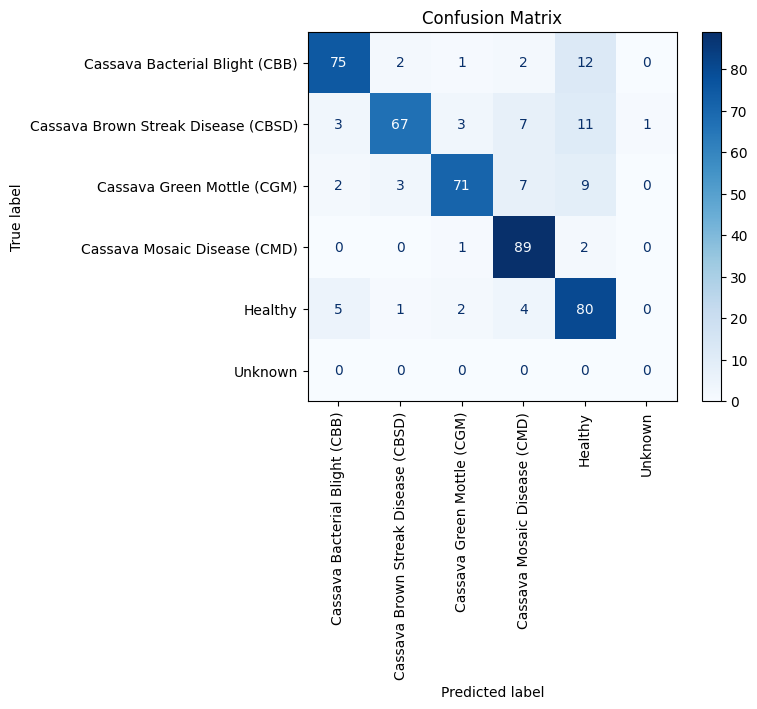

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Mapping dictionary
label_mapping = {
    0: 'Cassava Bacterial Blight (CBB)',
    1: 'Cassava Brown Streak Disease (CBSD)',
    2: 'Cassava Green Mottle (CGM)',
    3: 'Cassava Mosaic Disease (CMD)',
    4: 'Healthy',
    5: 'Unknown'
}

# Step 1: Create the confusion matrix
cm = confusion_matrix(validate_df['label'].values, predictions)

# Step 2: Map label indices to their names
label_names = [label_mapping[i] for i in range(len(label_mapping))]

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [61]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

true_labels = validate_df['label'].values

# Assuming you have the following variables:
# predictions: your predicted class indices
# true_labels: your true class labels from the dataframe

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, and F1-score (average='weighted' for multiclass)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print all metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate a classification report
report = classification_report(true_labels, predictions, target_names=list(label_mapping.values()))
print("Classification Report:\n", report)

Accuracy: 0.83
Precision: 0.85
Recall: 0.83
F1 Score: 0.83
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.88      0.82      0.85        92
Cassava Brown Streak Disease (CBSD)       0.92      0.73      0.81        92
         Cassava Green Mottle (CGM)       0.91      0.77      0.84        92
       Cassava Mosaic Disease (CMD)       0.82      0.97      0.89        92
                            Healthy       0.70      0.87      0.78        92
                            Unknown       0.00      0.00      0.00         0

                           accuracy                           0.83       460
                          macro avg       0.70      0.69      0.69       460
                       weighted avg       0.85      0.83      0.83       460



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p